# Вариант 7
* X1 ~ N(-1, 2), n1 = 100
* X2 ~ R(-2, 0), n2 = 100

* σ1 = 2, (m1 – не изв.)

In [69]:
import numpy as np
import seaborn as sns

from scipy import stats as st
from statsmodels.stats.descriptivestats import sign_test
import matplotlib.pyplot as plt

from typing import Dict, Tuple

In [2]:
n1 = 100
norm = st.distributions.norm(-1, 2).rvs(100, random_state=42)

In [65]:
n2 = 100
uniform = st.distributions.uniform.rvs(loc=-2, scale=2, size=100, random_state=42)

In [4]:
def describe_distribution(distribution, name) -> Dict[str, Dict[str, float]]:
    description = st.describe(distribution)

    return {
            name: {
                      'mean': description[2],
                      'variance': description[3],
                      'deviation': np.sqrt(description[3])
                  }
           }

In [5]:
describe_distribution(norm, 'norm')

{'norm': {'mean': -1.2076930347881878,
  'variance': 3.2990795745206403,
  'deviation': 1.8163368560156017}}

## 2. Визуализация выборки

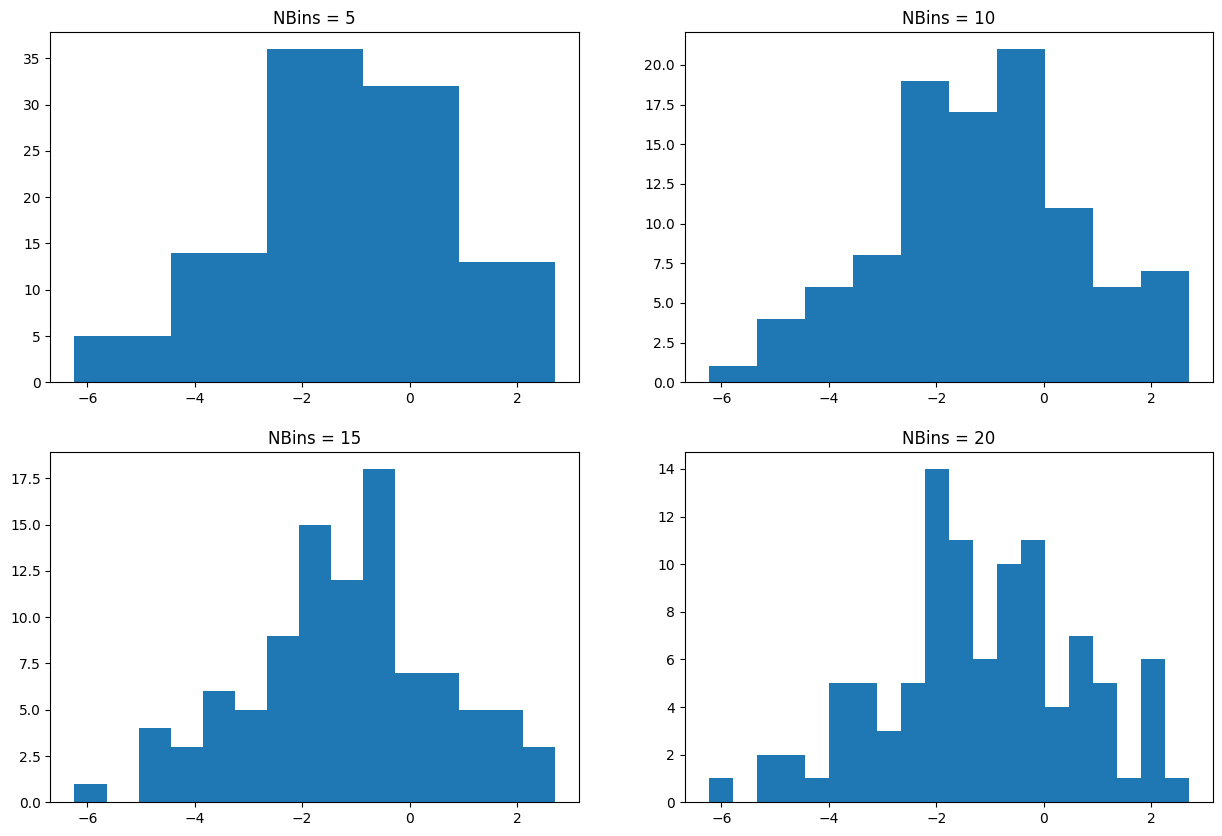

In [6]:
bins = [5, 10, 15, 20]

fig, ax = plt.subplots(len(bins) // 2, len(bins) // 2, figsize=(15,10))
index = 0

for i in range(len(bins) // 2):
    for j in range(len(bins) // 2):
        ax[i,j].hist(norm, bins = bins[index])
        ax[i, j].set_title('NBins = {}'.format(bins[index]))
        index += 1


fig.subplots_adjust(hspace = 0.2)


## Chi-Squared

In [53]:
class BinWorker:
    def __init__(self, n: int):
        self.n = n


    @staticmethod
    def bin_mean(a: np.array) -> np.array:
        means = np.zeros(a.shape[0] - 1)

        for i in range(means.shape[0]):
            means[i] = (a[i] + a[i+1]) / 2
        return means

    def calc_mean(self, values: np.array, freqs: np.array) -> np.array:
        return np.sum(self.bin_mean(values) * freqs) / self.n

    def calc_sigma(self, values: np.array, freqs: np.array) -> np.array:
        return (np.sum(pow((self.bin_mean(values) - self.calc_mean(values, freqs)), 2) * freqs) / self.n) ** (1/2)

    @staticmethod
    def freqs_to_probs(distribution, bins: np.array) -> np.array:
        probs = []
        for i in range(len(bins) - 1):
            probs.append(distribution.cdf(bins[i + 1]) - distribution.cdf(bins[i]))

        return np.array(probs)

    def get_np(self, nums: np.array, bins: np.array, distribution):
      nums, bins = nums.copy(), bins.copy()
      n = sum(nums)
      probs = list(self.freqs_to_probs(distribution, bins))
      i = 0

      while i < len(nums):
          p = probs[i]
          if p * n < 5 and i < len(probs)-1:
              nums[i:i+2] = [nums[i] + nums[i+1]]
              bins[i:i+2] = [bins[i]]
              probs[i:i+2] = [probs[i] + probs[i+1]]
              i-=1
          elif p * n < 5 and i == len(probs)-1:
            nums[i-1:i+1] = [nums[i-1] + nums[i]]
            bins[i-1:i+1] = [bins[i-1]]
            probs[i-1:i+1] = [probs[i-1] + probs[i]]
            i-=1

          i+=1

      return nums, probs

    def calc_chi_squared(self, n: np.array, p: np.array, params_quantity: int) -> Tuple[float, float]:
        z = sum(pow((n - self.n * p), 2) / (self.n * p))
        f = st.chi2.cdf(z, len(n) - params_quantity - 1)
        p_value = 2 * min(f, 1 - f)

        return z, p_value if not np.isnan(p_value) else 0.0

In [37]:
bins = [5, 10, 15, 20]

for bin in bins:
    f, v = np.histogram(norm, bins=bin)

    worker = BinWorker(n1)
    new_f, new_p = worker.get_np(f.tolist(), v.tolist(), st.norm(loc=-1, scale=2))

    z, p = worker.calc_chi_squared(np.array(new_f), np.array(new_p), 2)

    print(f"For {bin} Bins: Z: {z}; p: {p}")

For 5 Bins: Z: 0.5823084098402523; p: 0.8908178356511327
For 10 Bins: Z: 3.3902283167469522; p: 0.9895287937924258
For 15 Bins: Z: 7.755510412798474; p: 0.915419595802621
For 20 Bins: Z: 11.517106796051424; p: 0.6373461819311865


In [38]:
bins = [5, 10, 15, 20]

for bin in bins:
    f, v = np.histogram(norm, bins=bin)

    worker = BinWorker(n1)
    new_f, new_p = worker.get_np(f.tolist(), v.tolist(), st.uniform(loc=min(norm), scale=max(norm) - min(norm)))

    z, p = worker.calc_chi_squared(np.array(new_f), np.array(new_p), 2)

    print(f"For {bin} Bins: Z: {z}; p: {p}")

For 5 Bins: Z: 35.49999999999999; p: 3.911136214895805e-08
For 10 Bins: Z: 41.4; p: 1.3566224796868198e-06
For 15 Bins: Z: 52.699999999999996; p: 9.315317537339496e-07
For 20 Bins: Z: 52.599999999999994; p: 2.5775611423028977e-08


In [55]:
bins = [5, 10, 15, 20]

for bin in bins:
    f, v = np.histogram(norm, bins=bin)

    worker = BinWorker(n1)
    new_f, new_p = worker.get_np(f.tolist(), v.tolist(), st.chi2(5))
    z, p = worker.calc_chi_squared(np.array(new_f), np.array(new_p), 1)

    print(f"For {bin} Bins: Z: {z}; p: {p}")

For 5 Bins: Z: 218.26395966361645; p: 0.0
For 10 Bins: Z: 519.7345228763085; p: 0.0
For 15 Bins: Z: 788.0129676580689; p: 0.0
For 20 Bins: Z: 1012.4298119721584; p: 0.0


## Критерий Колмогорова

In [56]:
st.kstest(norm, st.norm.cdf, args=(-1, 2))

KstestResult(statistic=0.10357070563896065, pvalue=0.21805553378516235, statistic_location=-0.24860396330865608, statistic_sign=1)

In [58]:
st.kstest(norm, st.uniform.cdf, args=(-1, 1))

KstestResult(statistic=0.54, pvalue=8.032546727914933e-28, statistic_location=-1.0269944494758678, statistic_sign=1)

In [59]:
st.kstest(norm, st.chi2.cdf, args=(5,))

KstestResult(statistic=0.8728350968517201, pvalue=6.66609749824574e-90, statistic_location=1.1142444524378314, statistic_sign=1)

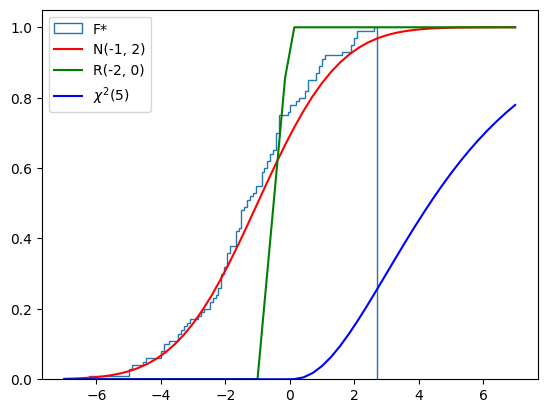

In [71]:
plt.hist(norm, histtype='step', cumulative=True, bins=len(norm), density=True)
x_values = np.linspace(-7,7);
plt.plot(x_values,st.norm.cdf(x_values, -1, 2), color='red',)
plt.plot(x_values,st.uniform.cdf(x_values, -1, 1), color='green')
plt.plot(x_values,st.chi2.cdf(x_values, 5), color = 'blue')
plt.legend (('F*', 'N(-1, 2)', 'R(-2, 0)', '$\chi^2(5)$'))
plt.show()

## Двухвыборочные критерии

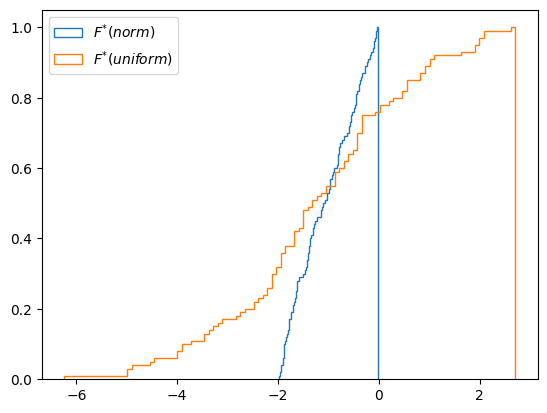

In [67]:
plt.hist(uniform, histtype='step', cumulative=True, bins=len(uniform), density=True)
plt.hist(norm, histtype='step', cumulative=True, bins=len(norm), density=True)
plt.legend (('$F^{*}(norm)$', '$F^{*}(uniform)$'))
plt.show()

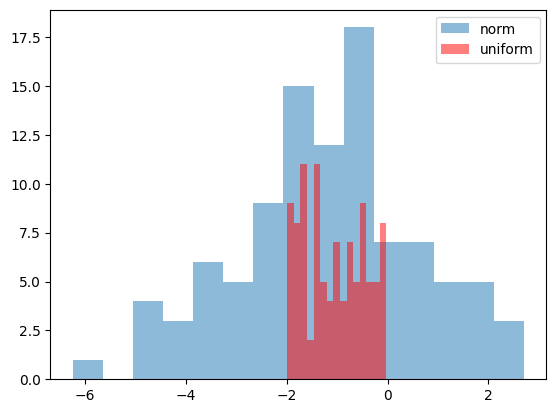

In [68]:
plt.hist(norm, alpha=0.5, bins=15)
plt.hist(uniform, alpha=0.5, bins=15, color='red')
plt.legend (('norm', 'uniform'))
plt.show()

In [72]:
norm_freq, _ = np.histogram(norm,  bins=15)
uniform_freq, _ = np.histogram(uniform, bins=15)

st.chisquare(f_obs=norm_freq, f_exp=uniform_freq)

Power_divergenceResult(statistic=75.3863997113997, pvalue=2.0099266995397252e-10)

In [73]:
st.ks_2samp(norm, uniform)

KstestResult(statistic=0.32, pvalue=6.281176788972264e-05, statistic_location=-1.921277541919575, statistic_sign=1)

In [70]:
sign_test([i-j for i, j in zip(norm, uniform)])

(4.0, 0.48411841360729146)

In [74]:
st.mannwhitneyu(norm, uniform)

MannwhitneyuResult(statistic=4683.0, pvalue=0.43932557741605893)